# 🍼 Baby Cry Classification - Full ML Pipeline
This notebook implements a complete machine learning pipeline for classifying different types of baby cries using audio features.


### Setup
Install required Python packages for audio processing, machine learning, and visualization.

In [1]:
%pip install librosa numpy pandas scikit-learn matplotlib seaborn xgboost imbalanced-learn joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Imports
Import necessary libraries for:
- Audio processing (librosa)
- Machine learning (scikit-learn, xgboost)
- Data handling (numpy, pandas)
- Visualization (matplotlib, seaborn)
- Model persistence (joblib)

In [2]:
# ▶️ 1. Imports
import os
import numpy as np
import librosa
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Feature Extraction
Define function to extract audio features:
- MFCCs (Mel-frequency cepstral coefficients)
- Chroma features
- Mel spectrogram
- Spectral contrast and tonnetz
- Time-domain features (zero crossing rate, energy)
- Spectral features (centroid, bandwidth, rolloff, flatness)

In [3]:
# ▶️ 2. Feature Extraction Functions

def extract_features(audio_input):
    try:
        # Handle both file paths and audio arrays
        if isinstance(audio_input, str):
            y, sr = librosa.load(audio_input, sr=16000)
        else:
            y = audio_input
            sr = 16000

        # Compute STFT
        stft = np.abs(librosa.stft(y))

        # Basic features
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

        # Time-domain features (ensure 1D)
        zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y))
        energy = np.mean(librosa.feature.rms(y=y))
        
        # Spectral features (ensure 1D)
        spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        spec_flatness = np.mean(librosa.feature.spectral_flatness(y=y))

        # Combine all features into a 1D array
        combined_features = np.concatenate([
            mfcc[:40],              # First 40 MFCCs
            chroma[:12],            # 12 chroma features
            mel[:40],               # First 40 mel features
            contrast[:7],           # 7 contrast features
            tonnetz[:6],            # 6 tonnetz features
            [zero_crossing],        # 1 feature
            [energy],               # 1 feature
            [spec_centroid],        # 1 feature
            [spec_bandwidth],       # 1 feature
            [spec_rolloff],         # 1 feature
            [spec_flatness]         # 1 feature
        ])

        return combined_features

    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        return None

### 3. Audio Augmentation
Implement data augmentation techniques for audio:
- Pitch shifting (up and down)
- Time stretching (faster and slower)
These help increase dataset size and model robustness.

In [4]:
# ▶️ 3. Audio Augmentation
def augment_audio(y, sr):
    augmented = []
    # Original audio
    augmented.append(y)
    # Pitch shifting (correct syntax)
    augmented.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2))    # pitch up
    augmented.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=-2))   # pitch down
    # Time stretching
    augmented.append(librosa.effects.time_stretch(y=y, rate=0.9))           # slower
    augmented.append(librosa.effects.time_stretch(y=y, rate=1.1))           # faster
    return augmented


### 4. Dataset Loading
Load and process audio files:
- Iterate through class folders
- Extract features from original audio
- Apply augmentation and extract features
- Handle errors gracefully

In [5]:
# ▶️ 4. Dataset Loading
def load_dataset(data_path):
    features, labels = [], []
    for label in os.listdir(data_path):
        folder_path = os.path.join(data_path, label)
        if not os.path.isdir(folder_path):
            continue
        print(f"Processing {label} files...")
        for file_name in os.listdir(folder_path):
            if not file_name.lower().endswith(('.wav', '.mp3', '.flac')):
                continue
            file_path = os.path.join(folder_path, file_name)
            try:
                # Load audio file
                y, sr = librosa.load(file_path, sr=16000)
                # Extract features from original and augmented versions
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(label)
                    # Process augmented versions
                    for aug_y in augment_audio(y, sr):
                        aug_features = extract_features(aug_y)
                        if aug_features is not None:
                            features.append(aug_features)
                            labels.append(label)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
    return np.array(features), np.array(labels)

### 5. Main Execution
Load the dataset from the specified path and extract features:
- Process all audio files
- Apply augmentation
- Display dataset statistics

In [6]:
# ▶️ 5. Main Execution
# Path to your cry dataset (each subfolder = class name)
data_path = "../dataset"   # 🔹 change this to your dataset path

print("Loading dataset...")
X, y = load_dataset(data_path)
print(f"✅ Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

Loading dataset...
Processing belly_pain files...
Processing burping files...
Processing discomfort files...
Processing hungry files...
Processing tired files...
✅ Dataset loaded: 2742 samples, 111 features


### 6. Preprocessing: Label Encoding & Split
- Convert class labels to numerical format
- Split data into training (80%) and test (20%) sets
- Maintain class distribution with stratification

In [7]:
# ▶️ 6. Label Encoding & Train-Test Split
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


### 7. Data Balancing
Apply SMOTE (Synthetic Minority Over-sampling Technique):
- Balance class distribution
- Create synthetic samples for minority classes

In [8]:
# ▶️ 7. Data Balancing with SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("✅ After SMOTE:", X_train.shape)

✅ After SMOTE: (9165, 111)


### 8. Feature Scaling
Standardize features:
- Fit StandardScaler on training data
- Transform both training and test data
- Ensure zero mean and unit variance

In [9]:
# ▶️ 8. Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 9. Feature Selection
Use RandomForest to select important features:
- Reduce dimensionality
- Keep most informative features
- Improve model efficiency

In [10]:
# ▶️ 9. Feature Selection using RandomForest
selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42))
selector.fit(X_train, y_train)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)
print("✅ Selected features:", X_train_sel.shape[1])

✅ Selected features: 39


### 10. Hyperparameter Tuning
Optimize parameters for multiple models:
- Random Forest (trees, depth, samples)
- SVM (kernel, C, gamma)
- KNN (neighbors, weights, metric)
Using GridSearchCV with cross-validation

In [11]:
# ▶️ 10. Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# === Random Forest Tuning ===
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_base = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_sel, y_train)
best_rf = rf_grid.best_estimator_
print("Best RF Params:", rf_grid.best_params_)


# === SVM Tuning ===
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly']
}
svm_base = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm_base, svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
svm_grid.fit(X_train_sel, y_train)
best_svm = svm_grid.best_estimator_
print("Best SVM Params:", svm_grid.best_params_)


# === KNN Tuning ===
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_base = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_base, knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
knn_grid.fit(X_train_sel, y_train)
best_knn = knn_grid.best_estimator_
print("Best KNN Params:", knn_grid.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best RF Params: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


### 11. Ensemble Model Setup
Create voting classifier combining:
- Random Forest
- SVM
- KNN
Using soft voting (probability-based)

In [12]:
# ▶️ 11. Ensemble Model (RF + SVM + KNN)
rf = best_rf
svm = best_svm
knn = best_knn

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('svm', svm), ('knn', knn)],
    voting='soft'
)

### 12. Cross Validation
Validate model performance:
- 5-fold stratified cross-validation
- Calculate mean accuracy across folds

In [13]:
# ▶️ 12. Cross Validation
print("\nPerforming Stratified 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_train_sel, y_train, cv=skf, scoring='accuracy')
print("Mean CV Accuracy:", np.mean(cv_scores))


Performing Stratified 5-Fold Cross-Validation...
Mean CV Accuracy: 0.9922531369339881


### 13. Final Training
Train the ensemble model on full training dataset

In [14]:
# ▶️ 13. Final Model Training
print("\nTraining final ensemble model...")
ensemble.fit(X_train_sel, y_train)


Training final ensemble model...


,estimators,"[('rf', ...), ('svm', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,300
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,1


### 14. Model Evaluation
Evaluate model performance:
- Classification report (precision, recall, F1-score)
- Overall accuracy

In [15]:
# ▶️ 14. Evaluation
y_pred = ensemble.predict(X_test_sel)
print("\n✅ Final Evaluation Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))


✅ Final Evaluation Report:
              precision    recall  f1-score   support

  belly_pain       0.75      0.63      0.69        19
     burping       0.88      0.70      0.78        10
  discomfort       0.82      0.84      0.83        32
      hungry       0.97      0.96      0.96       459
       tired       0.65      0.83      0.73        29

    accuracy                           0.93       549
   macro avg       0.81      0.79      0.80       549
weighted avg       0.93      0.93      0.93       549

Accuracy: 0.9289617486338798


### 15. Visualization
Plot confusion matrix:
- Show prediction distribution
- Identify common misclassifications

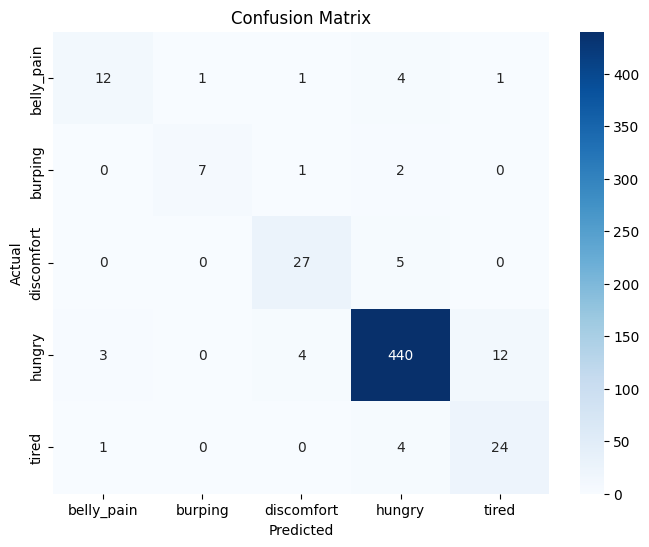

In [16]:
# ▶️ 15. Confusion Matrix Visualization
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 16. XGBoost Comparison
Train and evaluate XGBoost model:
- Compare performance with ensemble
- Additional benchmark

In [17]:
# ▶️ 16. Optional: XGBoost comparison
print("\nTraining XGBoost for comparison...")
xgb_model = xgb.XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_sel, y_train)
xgb_pred = xgb_model.predict(X_test_sel)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))


Training XGBoost for comparison...
XGBoost Accuracy: 0.9326047358834244


### 17. Model Persistence
Save trained models and preprocessing objects:
- Ensemble model
- Feature scaler
- Feature selector
- Label encoder
For later use in deployment

In [18]:
# ▶️ 17. Save the Trained Model and Encoder
os.makedirs("models", exist_ok=True)
joblib.dump(ensemble, "models/babycry_ensemble.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(selector, "models/feature_selector.pkl")
joblib.dump(le, "models/label_encoder.pkl")

print("\n🎉 Model, scaler, selector, and encoder saved successfully to 'models/' folder!")


🎉 Model, scaler, selector, and encoder saved successfully to 'models/' folder!
